- Load files and visualize car/noncar
- `findcars()`
    - HOG: `hog_generator(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)`. **Can also implement SIFT features**
    - `extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)`
        - Convert img to a color space
        - For each channel of the color space, 'R', 'G', 'B' or 'H', 'S', 'V'. Get the hog features for that particular channel `img[:, :, channel]` then stack all vectors together
    - Standard Scaler
    - Train/test split
    - Fit SVC on train set. Evaluate on test set.
    - Write the final `find_cars()` function
        - ystart, ystop : threshold
        - colorspace, hog_channel : can be RGB, HSV. Choose YUV. Determine which feature to stack
        - scale : for scaling the window
        - svc: classifier after training
- Test the `find_cars()` function on a few images with different test images. Also test with random images found on the internet?
- `draw_boxes(np.copy(frame), rectangles_coors)` : draw on an image. Always make copy.
- `heatmap()`
- `draw_cars(np.copy(frame), heatmap_labels)` : take in `heatmap_labels = (num_cars, labeled_array)`. Have to get nonzero coordinates based on the car index. Draw boxes based on the coordinates  

For my process_frame function (without history)
- `find_cars(frame, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)` to return `bboxes` : given the ystart, ystop boundaries, find all the bboxes with cars in them
- `heatmap(canvas, bboxes, threshold)` to return `rectangles_coors` : from the bounding boxes, generate heatmap of binary code so that we can use the `scipy.ndimage.measurements.label` to collapse all tiny boxes with cars in them into large regions. Also apply **threshold** to filter out for weak signals
- `draw_label_boxes(np.copy(frame), rectangles_coors)` : draw final bounding boxes on the video

In [2]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

Link to Pickle files: https://www.dropbox.com/s/rfl7h55k6bb26xr/car_dataset.p?dl=0

## Import & Visualize

In [25]:
car_dataset = pickle.load(open("car_dataset.p", "rb"))
cars, notcars = np.asarray(car_dataset['car']), np.asarray(car_dataset['noncar'])

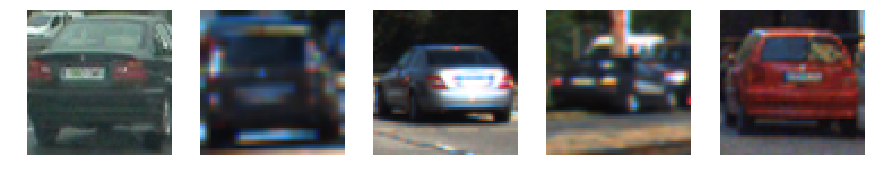

In [38]:
plt.figure(figsize=(15,15))
for i, img in enumerate(cars[np.random.randint(len(cars), size=5)]):   
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

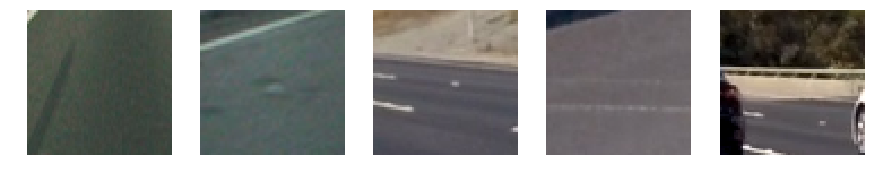

In [39]:
plt.figure(figsize=(15,15))
for i, img in enumerate(notcars[np.random.randint(len(cars), size=5)]):   
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# 1. Train a car classifier 

### HOG Features

In [73]:
from skimage.feature import hog
def get_hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), vis=False):
    """Extract HOG features from a channel
    
    skimage.feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), 
    block_norm=None, visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
    
    out : (n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient) ndarray
    HOG descriptor for the image. If feature_vector is True, a 1D (flattened) array is returned.

    hog_image : (M, N) ndarray, optional
    A visualisation of the HOG image. Only provided if visualize is True.
    """
    if vis:
        hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualise=vis)
        plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.show()
        return hog_features
    else:
        return hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)

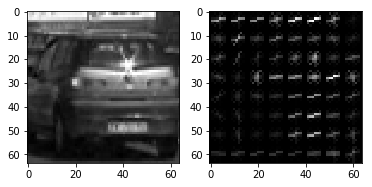

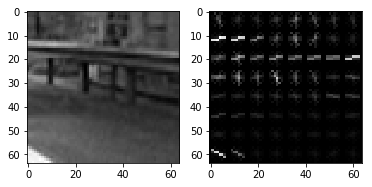

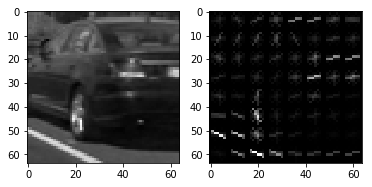

In [74]:
# Red Channel
_ = get_hog(cars[100][:,:,0], vis=True)
# Blue Channel
_ = get_hog(notcars[200][:,:,1], vis=True)
# Green Channel
_ = get_hog(cars[300][:,:,2], vis=True)

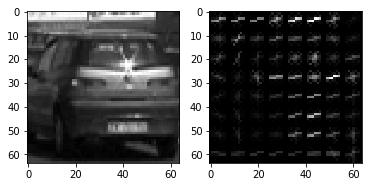

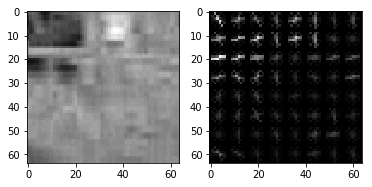

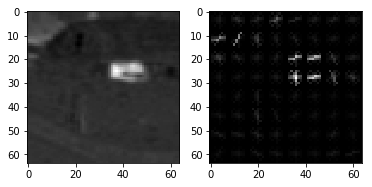

In [75]:
# Y Channel
_ = get_hog(cv2.cvtColor(cars[100], cv2.COLOR_RGB2YUV)[:,:,0], vis=True)
# U Channel
_ = get_hog(cv2.cvtColor(notcars[200], cv2.COLOR_RGB2YUV)[:,:,1], vis=True)
# V Channel
_ = get_hog(cv2.cvtColor(cars[300], cv2.COLOR_RGB2YUV)[:,:,2], vis=True)

### Extract features pipeline for all images in the dataset

In [84]:
def extract_features(data, method='HOG', cspace='RGB', orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), hog_channel='ALL'):
    """ Extract features for the dataset. Default is HOG.
    
    Returns: numpy array of (len(data), len(features)).
    """
    
    features = []
    # Loop through all images
    for image in data:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if method == 'HOG':
            hog_features = []
            if hog_channel == 'ALL':     
                # For-loop through all channel
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog(feature_image[:,:,channel], orientations=orientations, 
                                                              pixels_per_cell=pixels_per_cell, 
                                                              cells_per_block=cells_per_block))
                hog_features = np.ravel(hog_features) # Make 3 sub-channel features, into 1 single array       
            else:
                hog_features = get_hog(feature_image[:,:,hog_channel], orientations=orientations, 
                                                              pixels_per_cell=pixels_per_cell, 
                                                              cells_per_block=cells_per_block)

        if method == 'SIFT':
            # Todo
            continue

        # Append the new feature vector to the features list
        features.append(hog_features)
    return np.array(features).astype(np.float64)

In [85]:
cars_HOG_features = extract_features(cars, method='HOG', cspace='YUV', orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
notcars_HOG_features = extract_features(notcars, method='HOG', cspace='YUV', orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

In [86]:
print(cars_HOG_features.shape, notcars_HOG_features.shape)

(8792, 1188) (8968, 1188)


### Create X and y. Split to train/test

In [95]:
X = np.vstack([cars_HOG_features, notcars_HOG_features])
y = np.hstack([np.ones(cars_HOG_features.shape[0]), np.zeros(notcars_HOG_features.shape[0])])

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [109]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14208, 1188) (14208,) (3552, 1188) (3552,)


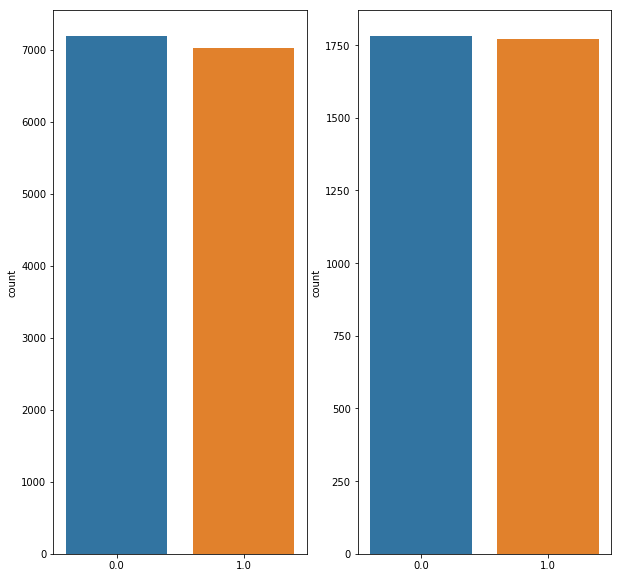

In [108]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.subplot(121)
sns.countplot(y_train)
plt.subplot(122)
sns.countplot(y_test)

In [110]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler # Helpful if we combine multiple methods. For now, it is just HOG.

svc_car = LinearSVC()
svc_car.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [111]:
print('Test Accuracy of SVC = ', round(svc_car.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.984


In [135]:
sample = mpimg.imread("test_images/test6.jpg")
hog_channel = 1
f = get_hog(cv2.cvtColor(sample, cv2.COLOR_RGB2YUV)[:,:,hog_channel], orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

In [136]:
f.shape

(152944,)